In [1]:
import pandas as pd

# Load datasets
low_scrap = pd.read_csv('/teamspace/studios/this_studio/dataset/low_scrap.csv')
high_scrap = pd.read_csv('/teamspace/studios/this_studio/dataset/high_scrap.csv')

# Basic data inspection
print("Low Scrap Dataset:")
print(low_scrap.head(), "\n")
print("High Scrap Dataset:")
print(high_scrap.head(), "\n")

# Check column structure
print("Columns in Low Scrap Dataset:")
print(low_scrap.columns, "\n")

print("Columns in High Scrap Dataset:")
print(high_scrap.columns, "\n")

# Confirm data types and missing values
print("Data Types and Missing Values in Low Scrap Dataset:")
print(low_scrap.info(), "\n")

print("Data Types and Missing Values in High Scrap Dataset:")
print(high_scrap.info(), "\n")

# Identify relevant target variable
target_variable = 'Station5_mp_85'
print(f"Target variable identified for causal analysis: {target_variable}")

# Save initial exploration results to guide further steps


Low Scrap Dataset:
   Station1_mp_0  Station1_mp_1  Station1_mp_2  Station1_mp_3  Station1_mp_4  \
0       0.000164           10.0            2.0       0.000224           15.0   
1       0.000240            8.0            2.0       0.000219           17.0   
2       0.000160           11.0            3.0       0.000189           14.0   
3       0.000173            9.0            3.0       0.000219           17.0   
4       0.000212            9.0            2.0       0.000205           13.0   

   Station1_mp_5  Station2_mp_6  Station2_mp_7  Station2_mp_8  Station2_mp_9  \
0            3.0   37577.464524       0.003730       55728.48       38647.52   
1            4.0   38731.386253       0.003738       56068.79       38993.59   
2            4.0   39404.300798       0.003647       56295.66       39024.36   
3            4.0   37393.410715       0.003700       54588.34       37205.51   
4            4.0   39265.722068       0.003616       55140.14       37751.55   

   ...  Station5_mp

In [2]:
from castle.algorithms import PC
import numpy as np

# Combining datasets and selecting numerical columns
combined_data = pd.concat([low_scrap, high_scrap], ignore_index=True)
numerical_data = combined_data.select_dtypes(include=[np.number])



# Run causal discovery with PC algorithm and check if it produces a graph
try:
    pc_model = PC(variant="stable", alpha=0.0001)
    graph = pc_model.learn(numerical_data.values)

    if graph is not None and hasattr(graph, 'adj'):
        adj_matrix = graph.adj
        print("Adjacency Matrix of Causal Graph (partial):")
        print(adj_matrix[:10, :10])  # Displaying a subset for inspection
    else:
        print("Graph learning did not return a valid adjacency matrix. Please check data and algorithm parameters.")
except Exception as e:
    print("An error occurred during causal discovery:", str(e))



2024-10-26 16:08:18,336 - /home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/castle/backend/__init__.py[line:36] - INFO: You can use `os.environ['CASTLE_BACKEND'] = backend` to set the backend(`pytorch` or `mindspore`).
2024-10-26 16:08:18,386 - /home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/castle/algorithms/__init__.py[line:36] - INFO: You are using ``pytorch`` as the backend.


Graph learning did not return a valid adjacency matrix. Please check data and algorithm parameters.


In [3]:
from sklearn.preprocessing import StandardScaler

In [4]:
from pgmpy.estimators import PC
from pgmpy.models import BayesianModel
from pgmpy.estimators import HillClimbSearch, BicScore
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

scaler = StandardScaler()

# Create DataFrame from the scaled data, maintaining the column names
scrap_scaled_df = pd.DataFrame(scaler.fit_transform(combined_data), columns=combined_data.columns)

# Initialize the PC algorithm from pgmpy
c = PC(scrap_scaled_df)
max_cond_vars = len(scrap_scaled_df.columns) - 2  # A parameter that can be tuned
model = c.estimate(return_type='dag', significance_level=0.02, max_cond_vars=max_cond_vars, ci_test='pearsonr')

# Visualizing the causal graph
nx_graph = nx.DiGraph()
nx_graph.add_edges_from(model.edges())
pos = nx.layout.circular_layout(nx_graph)
plt.figure(figsize=(12, 12))
nx.draw_networkx(nx_graph, pos, arrows=True, node_color='blue', edge_color='#000000', font_size=8, font_color='white')
plt.title('Causal Graph Estimated from Low Scrap Data')
plt.show()

  0%|          | 0/96 [00:00<?, ?it/s]

KeyboardInterrupt: 

  0%|          | 0/2 [00:00<?, ?it/s]

2024-10-26 15:27:57,228 - /home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/pgmpy/estimators/PC.py[line:369] - INFO: Reached maximum number of allowed conditional variables. Exiting


Number of edges in the causal graph after applying directional constraints: 62


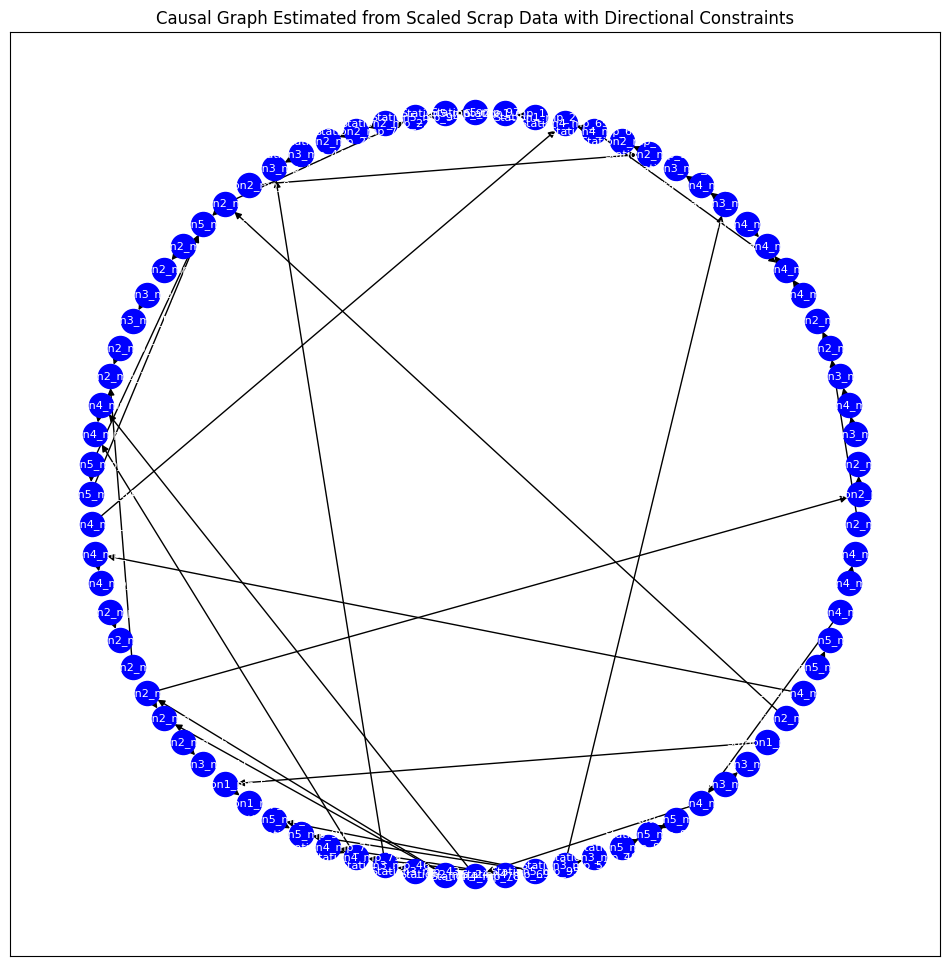

In [47]:
from pgmpy.estimators import PC
from pgmpy.models import BayesianModel
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Scale the combined data
scaler = StandardScaler()
scrap_scaled_df = pd.DataFrame(scaler.fit_transform(combined_data), columns=combined_data.columns)

# Initialize the PC algorithm
c = PC(scrap_scaled_df)
max_cond_vars = len(scrap_scaled_df.columns) - 2  # Tunable parameter
model = c.estimate(return_type='dag',
    variant="stable",  # Try stable variant instead of orig
    significance_level=0.001,  # Try different significance levels
    max_cond_vars=2,  # Limit the conditioning set size
    ci_test='pearsonr')

# Define a helper function to extract station number from column names
def get_station_num(column_name):
    # Assumes column names are structured like "Station2_mp_9"
    return int(column_name.split('_')[0].replace('Station', ''))

# Apply directional constraints: remove edges that go against station order
valid_edges = [(u, v) for u, v in model.edges() if get_station_num(u) <= get_station_num(v)]
model.remove_edges_from([edge for edge in model.edges() if edge not in valid_edges])

# Print the number of edges after applying directional constraints
num_edges = len(model.edges())
print("Number of edges in the causal graph after applying directional constraints:", num_edges)


# Visualize the causal graph
nx_graph = nx.DiGraph()
nx_graph.add_edges_from(model.edges())
pos = nx.layout.circular_layout(nx_graph)
plt.figure(figsize=(12, 12))
nx.draw_networkx(nx_graph, pos, arrows=True, node_color='blue', edge_color='#000000', font_size=8, font_color='white')
plt.title('Causal Graph Estimated from Scaled Scrap Data with Directional Constraints')
plt.show()


Adjacency Matrix after applying directional constraints:
120


In [5]:
import numpy as np

# Load the subset matrix from the file
filename = '/teamspace/studios/this_studio/head15.txt'
true_matrix = np.loadtxt(filename, dtype=int)

# Get the full list of column names from the high_scrap dataset
column_names = list(high_scrap.columns)

# Initialize the domain knowledge dictionary
domain_knowledge = {}

# Step 1: Apply mandatory presence constraints based on `true_matrix`
# Iterate over the available rows in `true_matrix` and all columns
for i in range(true_matrix.shape[0]):  # Only up to the number of rows in `true_matrix`
    for j in range(true_matrix.shape[1]):  # Full number of columns in `true_matrix`
        # Mandatory presence if there's a '1' in the true_matrix
        if true_matrix[i, j] == 1:
            domain_knowledge[(column_names[i], column_names[j])] = True

# Step 2: Apply mandatory absence constraints for reverse station order across the full dataset
for i in range(len(column_names)):
    for j in range(len(column_names)):
        # Extract station numbers from column names (e.g., "Station3_mp_45" -> 3)
        station_i = int(column_names[i].split('_')[0].replace('Station', ''))
        station_j = int(column_names[j].split('_')[0].replace('Station', ''))

        # Enforce absence if j is from a later station than i
        if station_j < station_i:
            domain_knowledge[(column_names[i], column_names[j])] = False


print(len(domain_knowledge))

3732


  0%|          | 0/20 [00:00<?, ?it/s]

Number of edges in the causal graph : 64


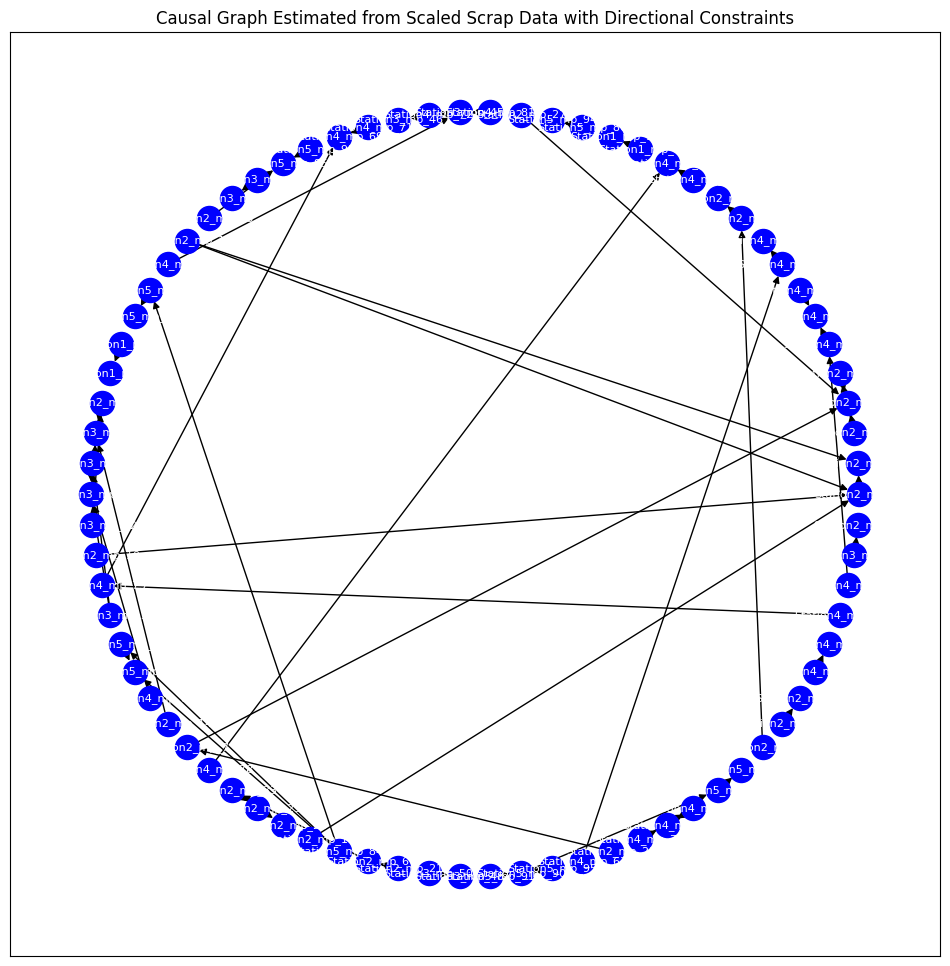

In [77]:
from pgmpy.estimators import PC
from pgmpy.models import BayesianModel



# Scale the combined data
scaler = StandardScaler()
high_scrap_scaled_df = pd.DataFrame(scaler.fit_transform(low_scrap), columns=combined_data.columns)

# Initialize and estimate with constraints
c = PC(high_scrap_scaled_df)
model = c.estimate(
    return_type='dag',
    variant="stable",
    significance_level=0.0000001,
    max_cond_vars=20,
    ci_test='pearsonr',
    black_list=[(u, v) for (u, v), present in domain_knowledge.items() if not present],
    white_list=[(u, v) for (u, v), present in domain_knowledge.items() if present]
)


# Print the number of edges after applying directional constraints
num_edges = len(model.edges())
print("Number of edges in the causal graph :", num_edges)


# Visualize the causal graph
nx_graph = nx.DiGraph()
nx_graph.add_edges_from(model.edges())
pos = nx.layout.circular_layout(nx_graph)
plt.figure(figsize=(12, 12))
nx.draw_networkx(nx_graph, pos, arrows=True, node_color='blue', edge_color='#000000', font_size=8, font_color='white')
plt.title('Causal Graph Estimated from Scaled Scrap Data with Directional Constraints')
plt.show()

In [10]:
from castle.algorithms import PC  # Import PC algorithm from gCastle
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Scale the combined data
scaler = StandardScaler()
combined_data_scaled = pd.DataFrame(scaler.fit_transform(combined_data), columns=combined_data.columns)

# Initialize and fit the causal discovery model
pc_model = PC(alpha=0.01)
pc_model.learn(combined_data_scaled.values)  # Use the scaled values as input for gCastle

# Extract adjacency matrix from learned causal structure
adjacency_matrix = pc_model.causal_matrix

# Remove edges that violate the station ordering constraint
column_names = combined_data.columns  # List of column names in the data

# Get station numbers from column names
station_numbers = [int(name.split('_')[0].replace('Station', '')) for name in column_names]

# Modify the adjacency matrix to remove edges that go from a higher station number to a lower one
for i in range(len(station_numbers)):
    for j in range(len(station_numbers)):
        # If the source station is greater than the target station, remove the edge
        if station_numbers[i] > station_numbers[j]:
            adjacency_matrix[i, j] = 0
from castle.algorithms import PC  # Import PC algorithm from gCastle
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

# Drop target if necessary
# Scale the combined data
scaler = StandardScaler()
combined_data_scaled = pd.DataFrame(scaler.fit_transform(combined_data), columns=combined_data.columns)

# Initialize and fit the causal discovery model
pc_model = PC(alpha= 0.5)
pc_model.learn(combined_data_scaled.values)  # Use the values as input for gCastle

# Extract adjacency matrix from learned causal structure
adjacency_matrix = pc_model.causal_matrix

# Convert adjacency matrix to graph for visualization
causal_graph = nx.from_numpy_array(adjacency_matrix, create_using=nx.DiGraph)

# Count the number of edges in the causal graph
num_edges = causal_graph.number_of_edges()
print("Number of edges in the causal graph:", num_edges)

# Visualize the causal graph
plt.figure(figsize=(12, 8))
nx.draw_networkx(causal_graph, with_labels=True, node_size=700, node_color='lightblue', font_size=10, font_weight='bold')
plt.title("Causal Graph of Features Influencing Scrap Rates (High Scrap Data)")
plt.show(
    causal_graph,
    with_labels=True,
    labels={i: column_names[i] for i in range(len(column_names))},
    node_size=700,
    node_color='lightblue',
    font_size=10,
    font_weight='bold'
)
plt.title("Causal Graph of Features Influencing Scrap Rates (High Scrap Data)")
plt.show()



KeyboardInterrupt: 

In [82]:
# Generate adjacency matrix
adjacency_matrix = pd.DataFrame(0, index=scrap_scaled_df.columns, columns=scrap_scaled_df.columns)
for edge in model.edges():
    adjacency_matrix.loc[edge[0], edge[1]] = 1

# Print adjacency matrix
print("Adjacency Matrix after applying directional constraints:")
adj_matrix_np = adjacency_matrix.to_numpy()



import numpy as np

# Replace 'matrix.txt' with the path to your text file
filename = '/teamspace/studios/this_studio/head15.txt'
# Load the matrix from the file
true_matrix = np.loadtxt(filename, dtype=int)

# count one in the true matrix
true_edges = np.count_nonzero(true_matrix)
print(true_edges)

Adjacency Matrix after applying directional constraints:
120


In [87]:
import numpy as np

# Assuming `true_matrix` is loaded and already has 15 rows
# Assuming `adjacency_matrix` is the result from the PC model

# Ensure `adjacency_matrix` has at least as many rows as `true_matrix`
adjacency_matrix_subset = adjacency_matrix[:15, :true_matrix.shape[1]]

# Find indices where `true_matrix` has 1s (required edges)
required_edges = np.argwhere(true_matrix == 1)

# Count missing edges in the adjacency matrix
missing_edges_count = sum(1 for (i, j) in required_edges if adjacency_matrix_subset[i, j] == 0)

print(f"Number of required edges from true_matrix that are missing in the adjacency matrix: {missing_edges_count}")


Number of required edges from true_matrix that are missing in the adjacency matrix: 98


In [84]:


# check how many ones from the true_matrix are present also in the adj_matrix_np, but not viceversa
true_matrix_ones = np.argwhere(true_matrix == 1)
adj_matrix_ones = np.argwhere(adj_matrix_np == 1)
true_matrix_ones_set = set(map(tuple, true_matrix_ones))
adj_matrix_ones_set = set(map(tuple, adj_matrix_ones))
false_positives = len(adj_matrix_ones_set - true_matrix_ones_set)
false_negatives = len(true_matrix_ones_set - adj_matrix_ones_set)
print(f"False positives: {false_positives}")

False positives: 61


[[0 1 1 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [33]:
adj_matrix_np

array([[0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])